In [7]:
from scipy import optimize
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt

##### BrentQ method to calculate IV of a single option 


In [8]:
def brent_q_impliedvol(S, K, T, r, market_price, option_type):

    def bsm_price(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            bsm_price = S * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)

        if option_type == 'put':
            bsm_price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0, 1) - S * si.norm.cdf(-d1, 0, 1)

        return bsm_price - market_price
    
    implied_vol = optimize.brentq(bsm_price, 0.0001, 5, maxiter=1000, xtol=1e-6)
    return implied_vol


In [9]:
brent_q_impliedvol(S=50, K = 40, T = 1, r = 0.05, market_price = 20, option_type = 'call')

0.7734127513736685

In [10]:
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import seaborn as sns

##### Set parameters of market

In [11]:
S0 = 100.0  #Spot
T = 1.0
r = 0.02
N = 252
M = 100000

In [12]:
kappa = 3  #Rate of mean reversion
theta = 0.20**2   # Long term vol
v0 = 0.25**2      #Initial vol
rho = 0.7         #Correlation of BM
sigma = 0.6       #Vol of Vol

##### Function to simulate prices and variances under Heston SDE

In [13]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    #Outputs asset prices over time, variance over time as numpy arrays

    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1, rho],
                   [rho,1]])            #Covariance matrix for S and V
    
    S = np.full(shape = (N+1, M), fill_value = S0)
    v = np.full(shape = (N+1, M), fill_value = v0)  #Arrays that store asset prices S and variances V

    Z = np.random.multivariate_normal(mu, cov, (N,M)) #Samples correlated brownian motion under Q

    for i in range(1, N+1):  #Discretisation of Eulers formula to get recursive formulas
        S[i] = S[i-1] * np.exp( ( r - 0.5*v[i-1])*dt + np.sqrt(v[i-1]*dt) * Z[i-1, :, 0])
        v[i] = np.maximum(v[i-1] + kappa*(theta - v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)* Z[i-1, :, 1], 0)

    return S, v


##### Example plots of prices and variances with high pos and neg corrlations

In [14]:
rho_p = 0.98  #Scenarios for high positive and negative correlations
rho_n = -0.98

S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N ,M)
S_n, v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N ,M)

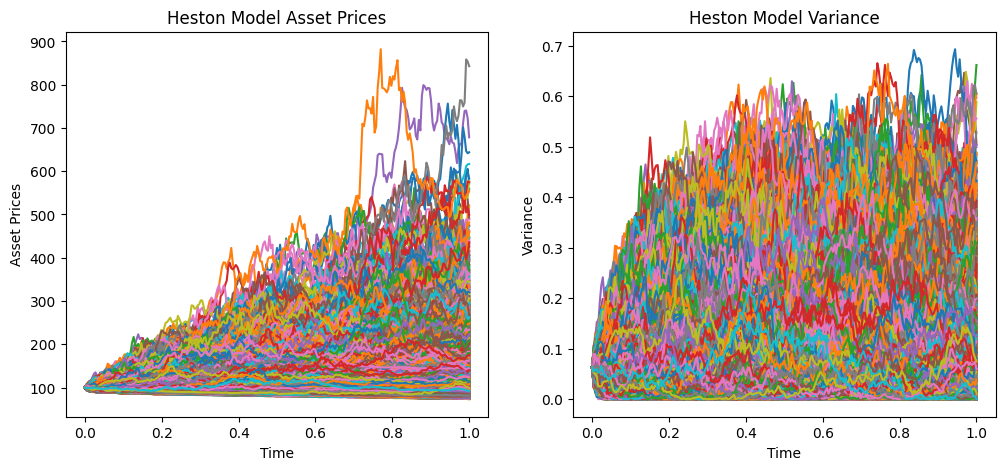

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
time = np.linspace(0, T, N+1)
ax1.plot(time, S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time, v_p)
ax2.set_title('Heston Model Variance')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

##### Input your markets rho, and plot volatility surface for calls and puts

In [16]:
rho = -0.7
S, v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)

In [17]:
K = np.arange(20, 180, 2)  #Different strike prices
puts = np.array([np.exp(-r*T) * np.mean(np.maximum(k-S, 0)) for k in K])
calls = np.array([np.exp(-r*T) * np.mean(np.maximum(S-k, 0)) for k in K])

In [18]:
put_ivs = implied_vol(puts, S0, K, T, r, flag = 'p', q = 0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag = 'c', q = 0, return_as='numpy')


c:\Users\sambu\AppData\Local\Programs\Python\Python312\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


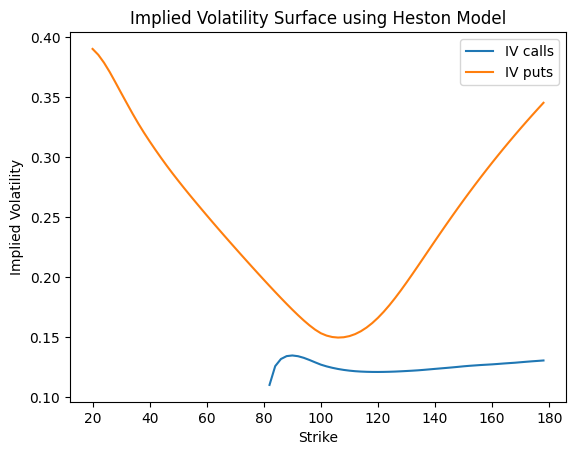

In [19]:
plt.plot(K, call_ivs, label = 'IV calls')
plt.plot(K, put_ivs, label = 'IV puts')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.title('Implied Volatility Surface using Heston Model')
plt.legend()
plt.show()

